In [1]:
import pandas as pd
import numpy as np

# visualization

import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('movie_data.csv', encoding='latin1')
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [3]:
df.shape

(15509, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [5]:
df.describe(include='all')

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
count,15509,14981,7240,13632,7919.000000,7920,14984,13892,13125,12365
unique,13838,102,182,485,NaN,2034,5938,4718,4891,4820
top,Anjaam,(2019),120 min,Drama,NaN,8,Jayant Desai,Ashok Kumar,Rekha,Pran
freq,7,410,240,2780,NaN,227,58,158,83,91
mean,NaN,NaN,NaN,NaN,5.841621,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.381777,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.100000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.900000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,6.800000,NaN,NaN,NaN,NaN,NaN


In [6]:
df.isnull().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

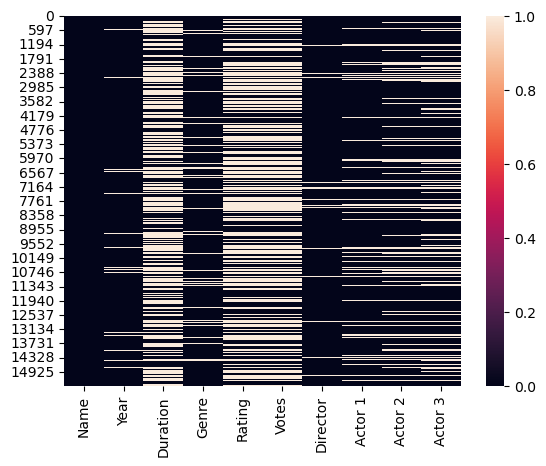

In [7]:
sns.heatmap(df.isnull());

In [8]:
missing_count = df.isnull().sum().sort_values(ascending=False)
missing_percent = (round(df.isnull().sum()/df.isnull().count(), 4)*100).sort_values(ascending=False)
missing_data = pd.concat([missing_count, missing_percent], 
                       axis=1, 
                       keys=['missing_count', 'missing_percent'])
missing_data

,missing_count,missing_percent
Duration,8269,53.32
Rating,7590,48.94
Votes,7589,48.93
Actor 3,3144,20.27
Actor 2,2384,15.37
Genre,1877,12.10
Actor 1,1617,10.43
Year,528,3.40
Director,525,3.39
Name,0,0.00


In [9]:
df.dropna(subset=['Rating'], inplace=True)

(round(df.isnull().sum()/df.isnull().count(), 4)*100).sort_values(ascending=False)

Duration    26.11
Actor 3      3.69
Actor 2      2.53
Actor 1      1.58
Genre        1.29
Director     0.06
Name         0.00
Year         0.00
Rating       0.00
Votes        0.00
dtype: float64

In [10]:
df.dropna(subset=['Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Genre'], inplace=True)

(round(df.isnull().sum()/df.isnull().count(), 4)*100).sort_values(ascending=False)

Duration    25.13
Name         0.00
Year         0.00
Genre        0.00
Rating       0.00
Votes        0.00
Director     0.00
Actor 1      0.00
Actor 2      0.00
Actor 3      0.00
dtype: float64

In [11]:
df['Duration'] = pd.to_numeric(df['Duration'].str.strip(' min'))
df['Duration'].fillna(df['Duration'].mean(), inplace=True)

df.isnull().sum()

Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

In [12]:
df.drop_duplicates(inplace=True)
df.shape

(7558, 10)

In [13]:
df['Year'] = df['Year'].apply(lambda x: x.split(')')[0])

year_lst = []
for val in df['Year']:
    if len(val.split('(')) == 1:
        year_lst.append(val.split('(')[0])
    elif len(val.split('(')) > 1:
        year_lst.append(val.split('(')[1])
df['Year'] = year_lst

In [14]:
df['Votes'] = df['Votes'].str.replace(',', '').astype(int)
df['Year'] = df['Year'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7558 entries, 1 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      7558 non-null   object 
 1   Year      7558 non-null   int32  
 2   Duration  7558 non-null   float64
 3   Genre     7558 non-null   object 
 4   Rating    7558 non-null   float64
 5   Votes     7558 non-null   int32  
 6   Director  7558 non-null   object 
 7   Actor 1   7558 non-null   object 
 8   Actor 2   7558 non-null   object 
 9   Actor 3   7558 non-null   object 
dtypes: float64(2), int32(2), object(6)
memory usage: 590.5+ KB


In [15]:
df['Year'].unique()

array([2019, 1997, 2005, 2012, 2014, 2004, 2016, 1991, 2018, 2010, 1958,
       2021, 2017, 2009, 1993, 2002, 1946, 2008, 1994, 2007, 2013, 2003,
       1998, 1979, 1974, 2015, 2006, 1981, 2020, 1985, 2011, 1988, 1995,
       1987, 1999, 1973, 1968, 1953, 1986, 1982, 1977, 1950, 1969, 1948,
       1967, 1970, 1990, 1989, 1947, 2001, 2000, 1971, 1978, 1944, 1963,
       1992, 1976, 1984, 1975, 1980, 1966, 1972, 1956, 1960, 1964, 1952,
       1959, 1951, 1954, 1962, 1961, 1957, 1965, 1996, 1933, 1955, 1983,
       1936, 1949, 1940, 1945, 1938, 1941, 1942, 1932, 1935, 1937, 1931,
       1943, 1917, 1939, 1934])

In [16]:
(df['Duration']>180).sum()

113

In [17]:
(df['Duration']<60).sum()

27

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7558 entries, 1 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      7558 non-null   object 
 1   Year      7558 non-null   int32  
 2   Duration  7558 non-null   float64
 3   Genre     7558 non-null   object 
 4   Rating    7558 non-null   float64
 5   Votes     7558 non-null   int32  
 6   Director  7558 non-null   object 
 7   Actor 1   7558 non-null   object 
 8   Actor 2   7558 non-null   object 
 9   Actor 3   7558 non-null   object 
dtypes: float64(2), int32(2), object(6)
memory usage: 590.5+ KB


In [19]:
df[['Rating', 'Duration', 'Votes']].describe(percentiles=[0.75,0.8, 0.9, 0.95, 0.98])

,Rating,Duration,Votes
count,7558.000000,7558.000000,7558.000000
mean,5.811127,133.439124,2029.123842
std,1.368255,21.908841,11868.695754
min,1.100000,21.000000,5.000000
50%,6.000000,133.439124,61.000000
75%,6.800000,144.000000,456.000000
80%,7.000000,149.000000,797.600000
90%,7.400000,160.000000,3182.900000
95%,7.800000,169.000000,8662.150000
98%,8.200000,180.000000,21935.900000


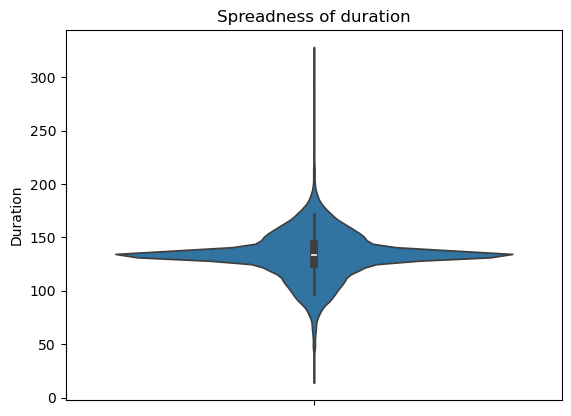

In [20]:
sns.violinplot(y=df['Duration'])
plt.title('Spreadness of duration')
plt.show()

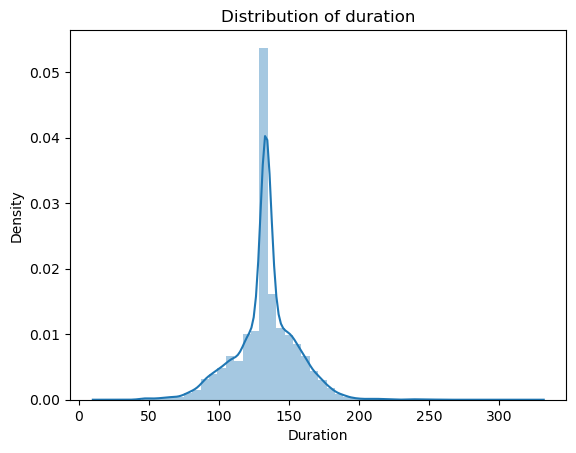

In [21]:
sns.distplot(df['Duration'])
plt.title('Distribution of duration')
plt.show()

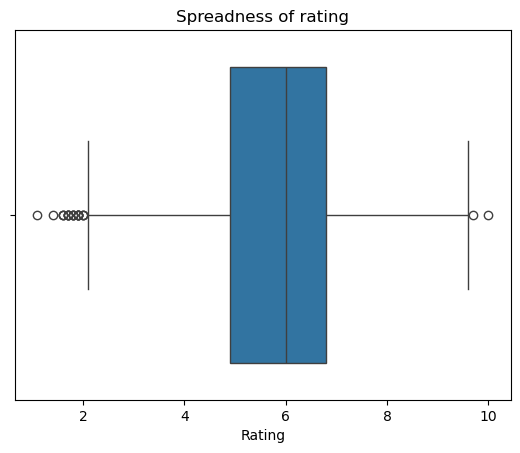

In [22]:
sns.boxplot(x=df['Rating'])
plt.title('Spreadness of rating')
plt.show()

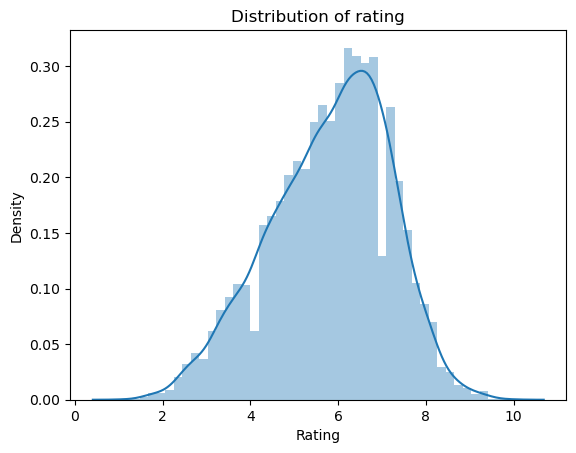

In [23]:
sns.distplot(df['Rating'])
plt.title('Distribution of rating')
plt.show()

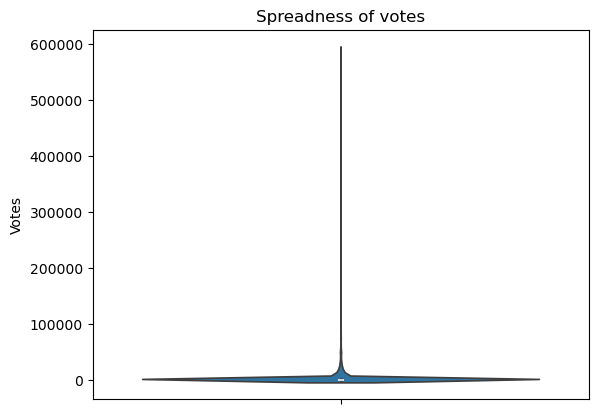

In [24]:
sns.violinplot(y=df['Votes'])
plt.title('Spreadness of votes')
plt.show()

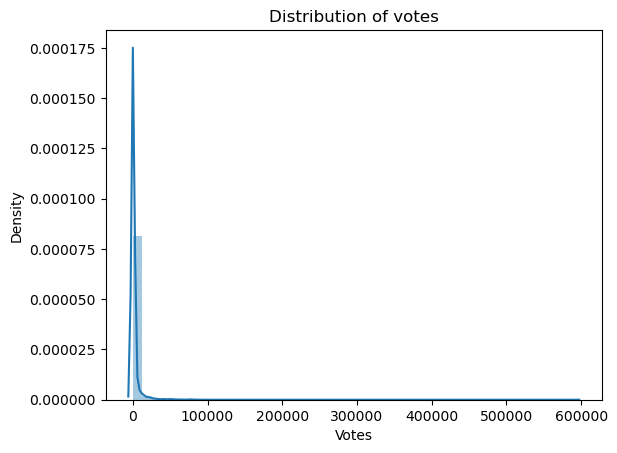

In [25]:
sns.distplot(df['Votes'])
plt.title('Distribution of votes')
plt.show()

In [26]:
df[df['Votes']>100000]

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
75,3 Idiots,2009,170.0,"Comedy, Drama",8.4,357889,Rajkumar Hirani,Aamir Khan,Madhavan,Mona Singh
3410,Dangal,2016,161.0,"Action, Biography, Drama",8.4,165074,Nitesh Tiwari,Aamir Khan,Sakshi Tanwar,Fatima Sana Shaikh
3829,Dil Bechara,2020,101.0,"Comedy, Drama, Romance",6.6,117377,Mukesh Chhabra,Sushant Singh Rajput,Sanjana Sanghi,Sahil Vaid
4848,Gandhi,1982,191.0,"Biography, Drama, History",8.0,220118,Richard Attenborough,Ben Kingsley,John Gielgud,Rohini Hattangadi
8035,Lagaan: Once Upon a Time in India,2001,224.0,"Drama, Musical, Sport",8.1,107234,Ashutosh Gowariker,Aamir Khan,Raghuvir Yadav,Gracy Singh
8219,Life of Pi,2012,127.0,"Adventure, Drama, Fantasy",7.9,591417,Ang Lee,Suraj Sharma,Irrfan Khan,Adil Hussain
8228,Like Stars on Earth,2007,165.0,"Drama, Family",8.4,175810,Aamir Khan,Amole Gupte,Darsheel Safary,Aamir Khan
8233,Lion,2016,118.0,"Biography, Drama",8.0,220526,Garth Davis,Dev Patel,Nicole Kidman,Rooney Mara
9764,My Name Is Khan,2010,165.0,Drama,8.0,101014,Karan Johar,Shah Rukh Khan,Kajol,Sheetal Menon
10882,PK,2014,153.0,"Comedy, Drama, Musical",8.1,168150,Rajkumar Hirani,Aamir Khan,Anushka Sharma,Sanjay Dutt


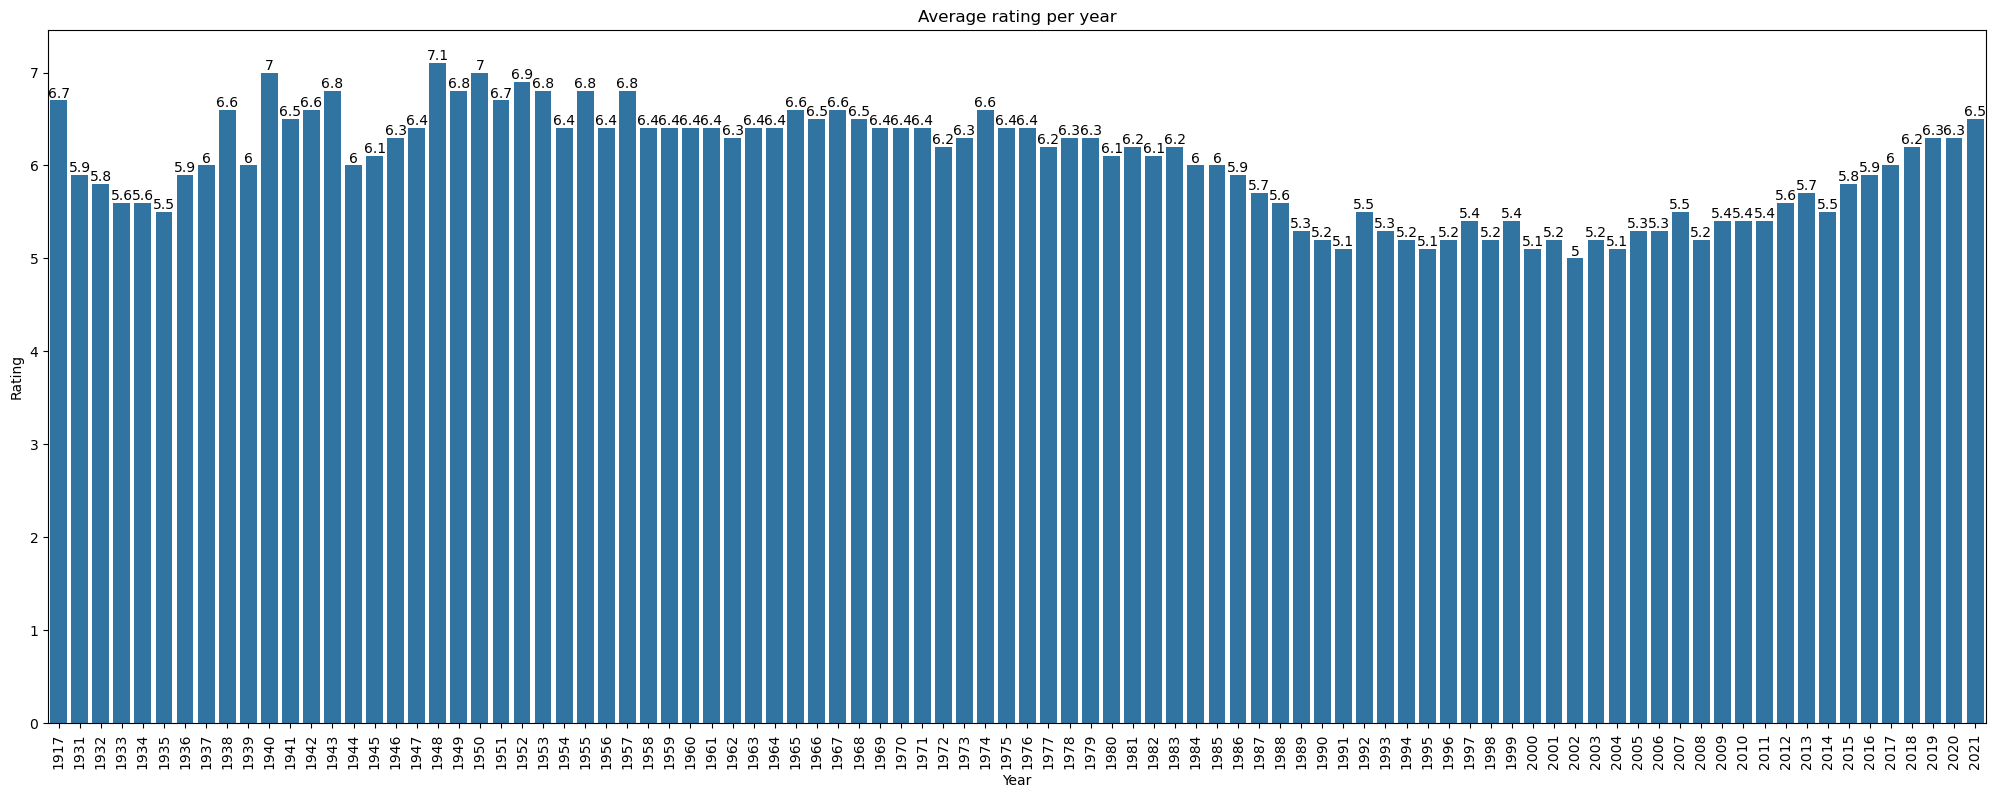

In [27]:
# Average rating per year
year_rating = df.groupby('Year').agg({'Rating': 'mean'}).reset_index().sort_values(by='Rating',ascending=False)
year_rating['Rating'] = round(year_rating['Rating'],1)

plt.figure(figsize=(25,9))
ax = sns.barplot(data=year_rating, x='Year', y='Rating')
ax.bar_label(ax.containers[0])
plt.title('Average rating per year')
plt.xticks(rotation=90)
plt.show()

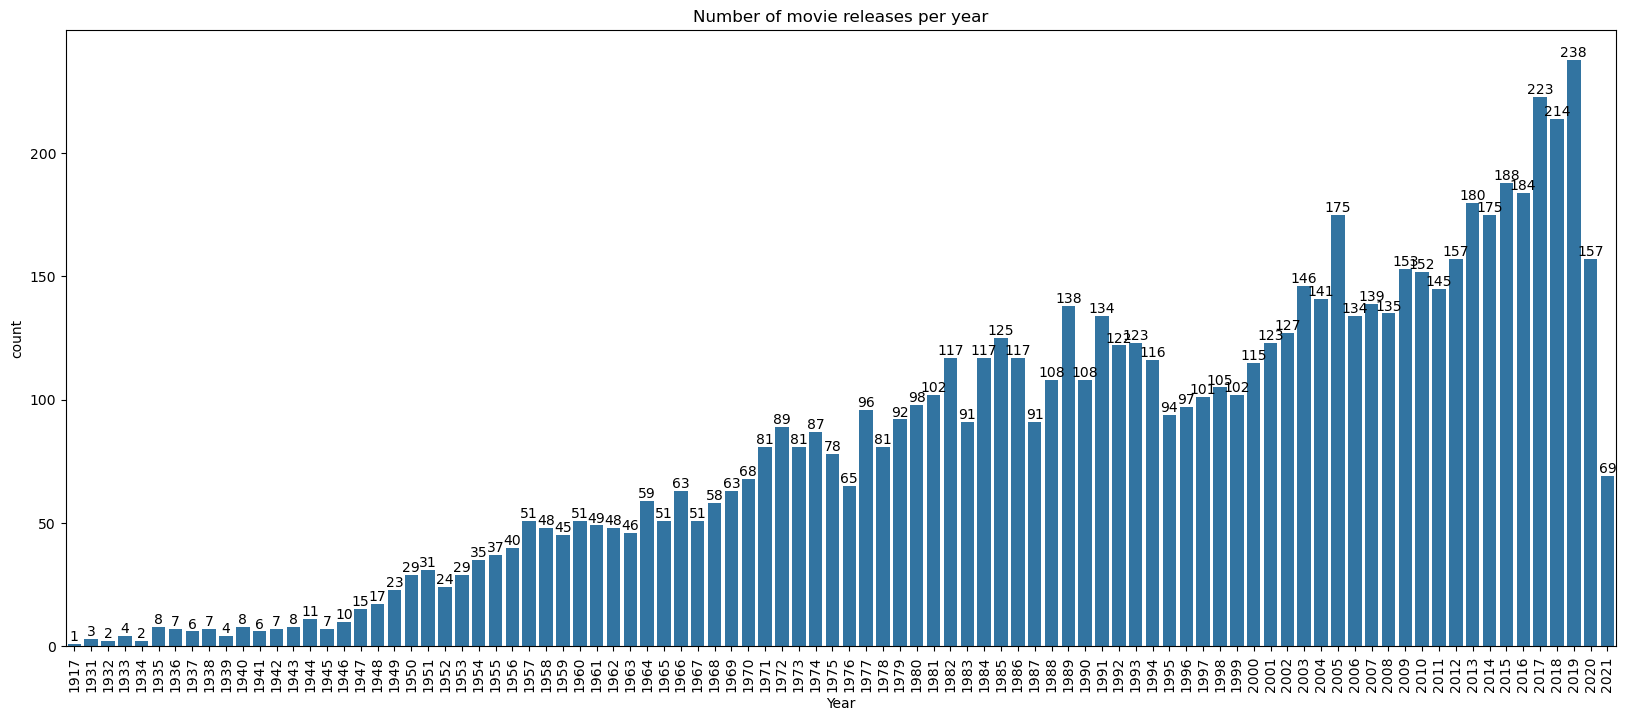

In [29]:
# Number of movie release per year
year_count = df.groupby('Year').agg({'Name':'count'}).rename(columns={'Name':'count'}).\
                                        sort_values(by='count', ascending=False).reset_index()
plt.figure(figsize=(20,8))
ax = sns.barplot(data=year_count, x='Year', y='count')
ax.bar_label(ax.containers[0])
plt.title('Number of movie releases per year')
plt.xticks(rotation=90)
plt.show()

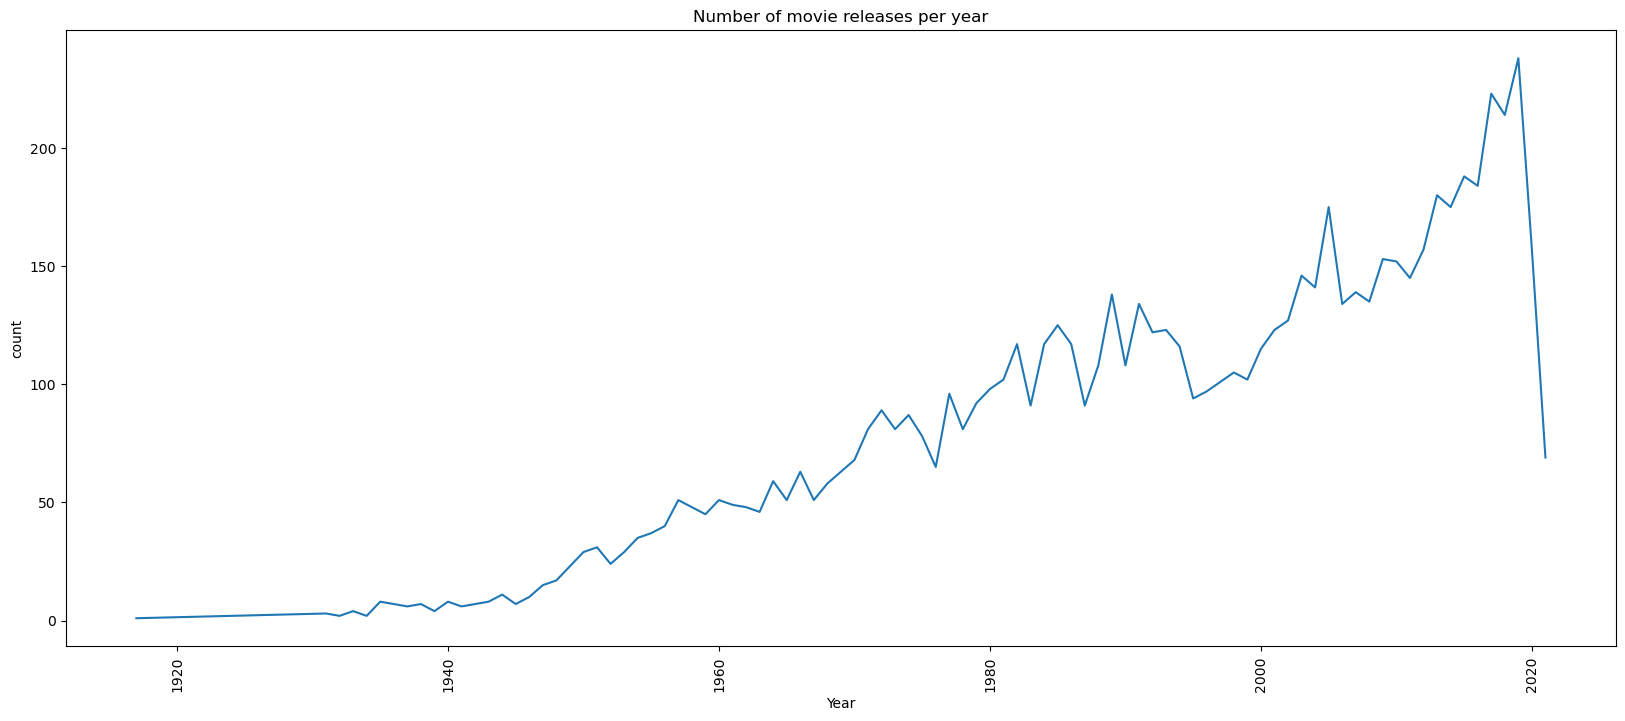

In [30]:
plt.figure(figsize=(20,8))
ax = sns.lineplot(data=year_count, x='Year', y='count')
plt.title('Number of movie releases per year')
plt.xticks(rotation=90)
plt.show()

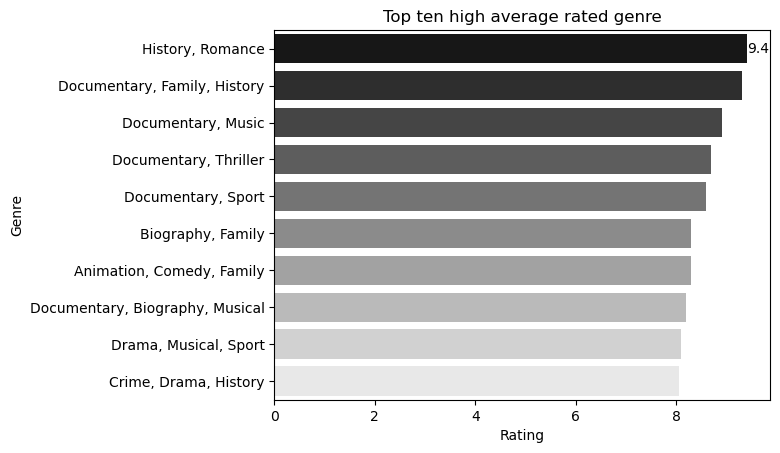

In [31]:
# plot top ten high average rated genre 
genre_rate = df.groupby('Genre').agg({'Rating':'mean'}).sort_values(by='Rating', ascending=False)\
                                .reset_index().head(10)

ax = sns.barplot(data=genre_rate, x='Rating', y='Genre', palette='gist_gray')
ax.bar_label(ax.containers[0])
plt.title('Top ten high average rated genre')
plt.show()

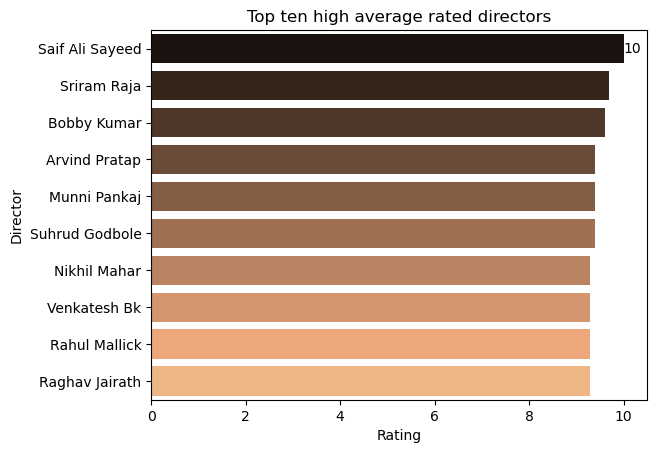

In [32]:
# plot top ten high average rating directors
director_rate = df.groupby('Director').agg({'Rating':'mean'}).sort_values(by='Rating', ascending=False)\
                                      .reset_index().head(10)

ax = sns.barplot(data=director_rate, x='Rating', y='Director', palette='copper')
ax.bar_label(ax.containers[0])
plt.title('Top ten high average rated directors')
plt.show()

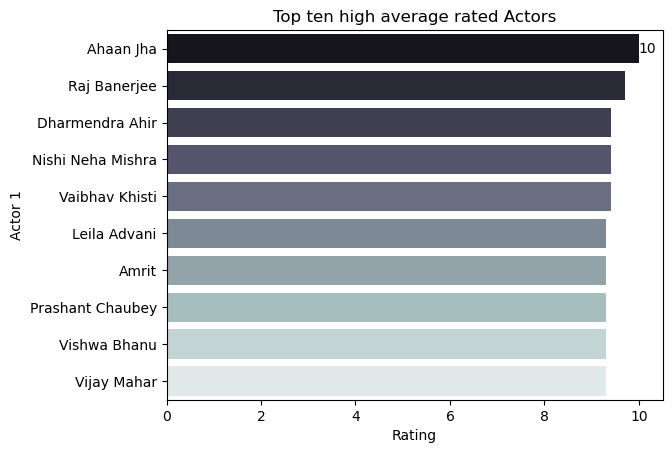

In [33]:
# plot top ten high average rating actors
actor1_rate = df.groupby('Actor 1').agg({'Rating':'mean'}).sort_values(by='Rating', ascending=False)\
                                      .reset_index().head(10)

ax = sns.barplot(data=actor1_rate, x='Rating', y='Actor 1', palette='bone')
ax.bar_label(ax.containers[0])
plt.title('Top ten high average rated Actors')
plt.show()

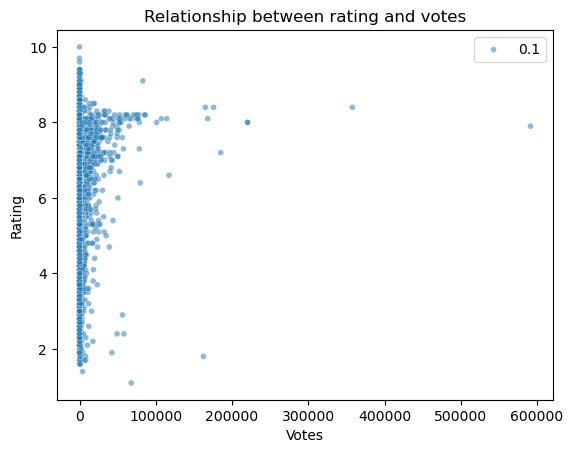

In [34]:
sns.scatterplot(data=df, x='Votes', y='Rating', size=0.1, alpha=0.5)
plt.title('Relationship between rating and votes')
plt.show()

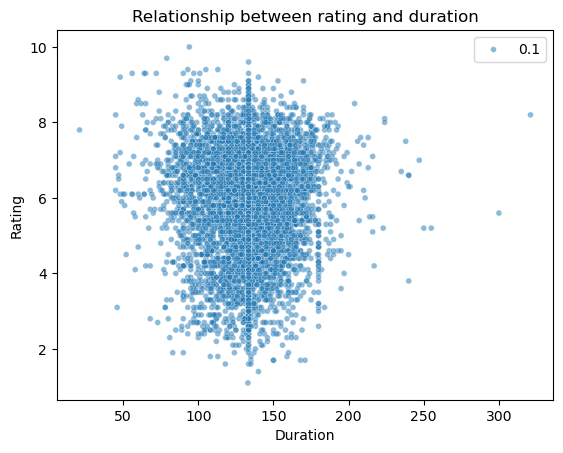

In [35]:
sns.scatterplot(data=df, x='Duration', y='Rating', size=0.1, alpha=0.5)
plt.title('Relationship between rating and duration')
plt.show()

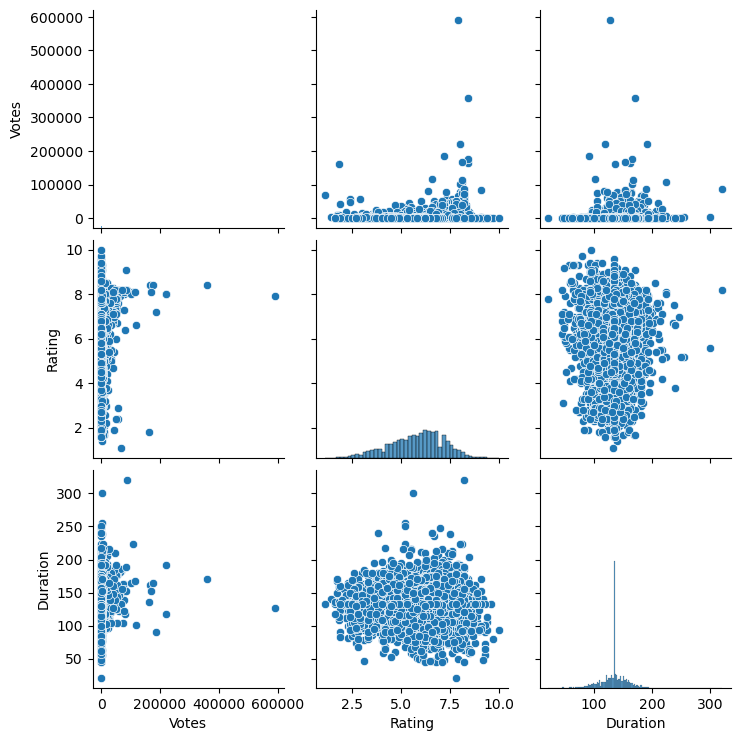

In [36]:
sns.pairplot(df[['Votes', 'Rating', 'Duration']]);

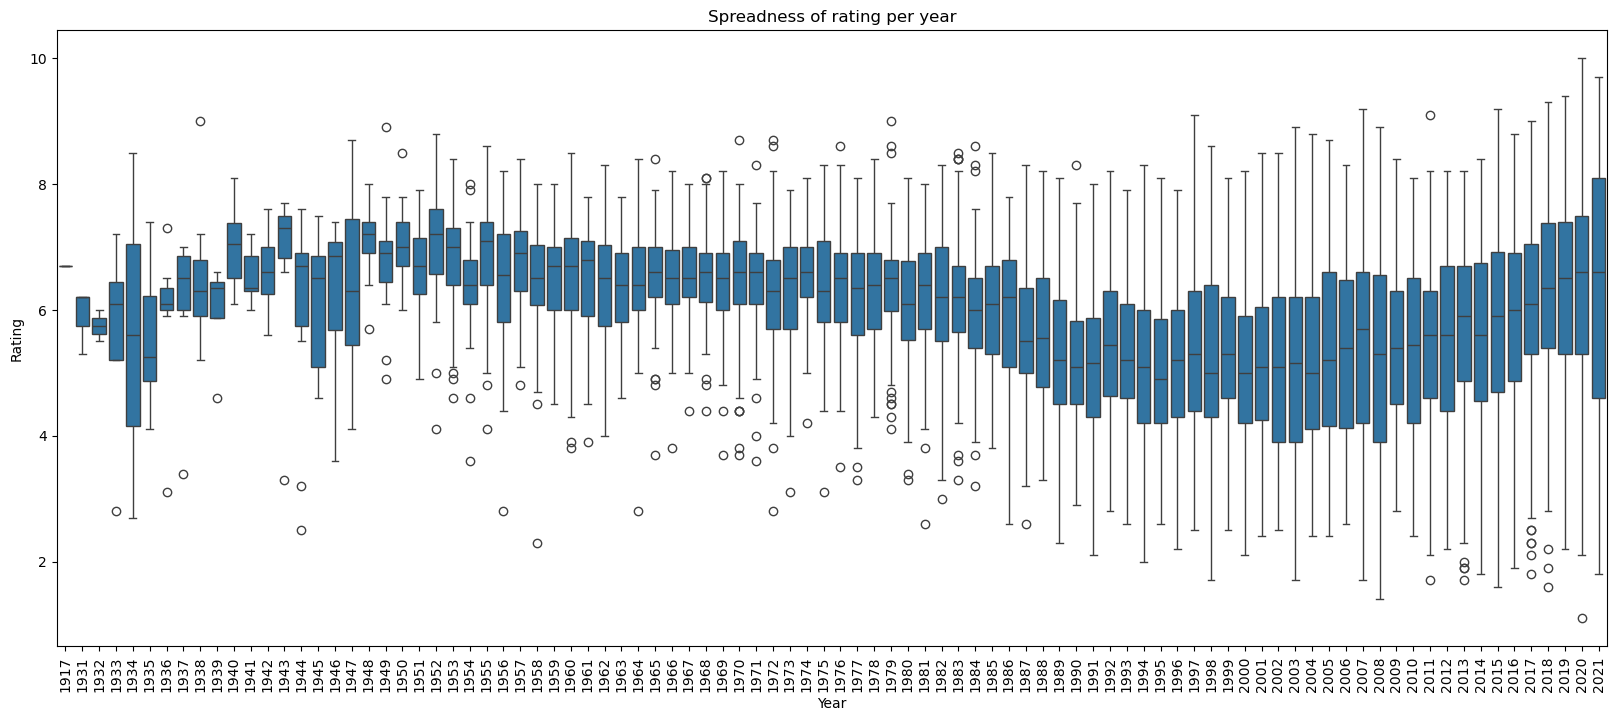

In [37]:
plt.figure(figsize=(20,8))
sns.boxplot(data=df, x='Year', y='Rating')
plt.title('Spreadness of rating per year')
plt.xticks(rotation=90)
plt.show()

In [38]:
df_update = df.drop(['Name'], axis=1)

In [39]:
df_update.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7558 entries, 1 to 15508
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      7558 non-null   int32  
 1   Duration  7558 non-null   float64
 2   Genre     7558 non-null   object 
 3   Rating    7558 non-null   float64
 4   Votes     7558 non-null   int32  
 5   Director  7558 non-null   object 
 6   Actor 1   7558 non-null   object 
 7   Actor 2   7558 non-null   object 
 8   Actor 3   7558 non-null   object 
dtypes: float64(2), int32(2), object(5)
memory usage: 531.4+ KB


In [40]:
actor1_encoding_map = df_update.groupby('Actor 1').agg({'Rating': 'mean'}).to_dict()
actor2_encoding_map = df_update.groupby('Actor 2').agg({'Rating': 'mean'}).to_dict()
actor3_encoding_map = df_update.groupby('Actor 3').agg({'Rating': 'mean'}).to_dict()
director_encoding_map = df_update.groupby('Director').agg({'Rating': 'mean'}).to_dict()
genre_encoding_map = df_update.groupby('Genre').agg({'Rating': 'mean'}).to_dict()

In [41]:
df_update['actor1_encoded'] = round(df_update['Actor 1'].map(actor1_encoding_map['Rating']),1)
df_update['actor2_encoded'] = round(df_update['Actor 2'].map(actor2_encoding_map['Rating']),1)
df_update['actor3_encoded'] = round(df_update['Actor 3'].map(actor3_encoding_map['Rating']),1)
df_update['director_encoded'] = round(df_update['Director'].map(director_encoding_map['Rating']),1)
df_update['genre_encoded'] = round(df_update['Genre'].map(genre_encoding_map['Rating']),1)

In [42]:
df_update.drop(['Actor 1', 'Actor 2', 'Actor 3', 'Director', 'Genre'], axis=1, inplace=True)
df_update.head()

,Year,Duration,Rating,Votes,actor1_encoded,actor2_encoded,actor3_encoded,director_encoded,genre_encoded
1,2019,109.0,7.0,8,6.8,7.0,7.0,7.0,6.3
3,2019,110.0,4.4,35,5.4,4.4,4.4,4.4,5.7
5,1997,147.0,4.7,827,4.8,5.8,5.8,5.4,6.2
6,2005,142.0,7.4,1086,5.3,6.0,6.5,7.5,6.8
8,2012,82.0,5.6,326,5.6,5.9,5.6,5.6,5.5


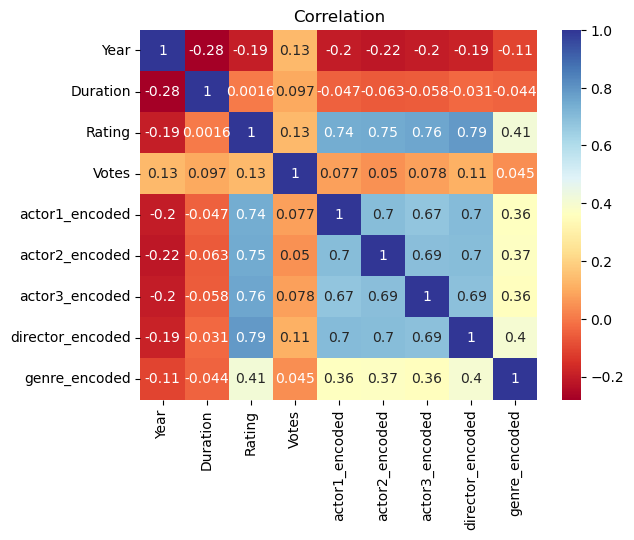

In [43]:
sns.heatmap(df_update.corr(), annot=True, cmap='RdYlBu')
plt.title('Correlation')
plt.show()

In [44]:
X = df_update.drop('Rating', axis=1)
y = df_update['Rating']

X.head()

,Year,Duration,Votes,actor1_encoded,actor2_encoded,actor3_encoded,director_encoded,genre_encoded
1,2019,109.0,8,6.8,7.0,7.0,7.0,6.3
3,2019,110.0,35,5.4,4.4,4.4,4.4,5.7
5,1997,147.0,827,4.8,5.8,5.8,5.4,6.2
6,2005,142.0,1086,5.3,6.0,6.5,7.5,6.8
8,2012,82.0,326,5.6,5.9,5.6,5.6,5.5


In [45]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
print('Shape of training features: ', X_train.shape)
print('Shape of training target: ', y_train.shape)
print('Shape of testing features: ', X_test.shape)
print('Shape of testing target: ', y_test.shape)

Shape of training features:  (6046, 8)
Shape of training target:  (6046,)
Shape of testing features:  (1512, 8)
Shape of testing target:  (1512,)


In [47]:
# Initiate the model and fit into the training data
LR = LinearRegression()
LR.fit(X_train, y_train)

# Evaluate the model performance on the training data
print('Coefficient of determination: ', LR.score(X_train, y_train))

Coefficient of determination:  0.7613579123839522


In [48]:
# Evaluate the model performance on the test data
y_pred_LR = LR.predict(X_test)

print('R^2: ', r2_score(y_test, y_pred_LR))
print('MAE: ',mean_absolute_error(y_test, y_pred_LR))
print('MSE: ', mean_squared_error(y_test, y_pred_LR))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_LR)))

R^2:  0.7580529126852419
MAE:  0.4983995226829541
MSE:  0.4482886095535746
RMSE:  0.6695435830127674


In [49]:
# Create a `results` dataframe
results = pd.DataFrame({'actual': y_test,
                        'predicted': y_pred_LR.ravel(),
                        'residual': y_test - y_pred_LR}
                      )
results.head()

,actual,predicted,residual
6241,7.4,6.617484,0.782516
3321,4.9,5.485182,-0.585182
6117,6.5,6.324062,0.175938
5975,5.7,5.552979,0.147021
6653,7.0,6.973330,0.026670


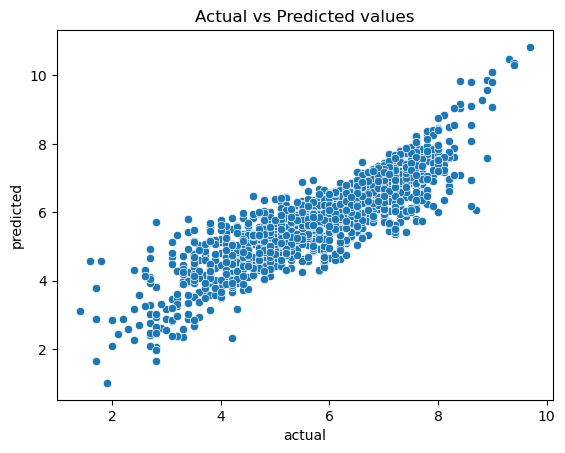

In [50]:
# Create a scatterplot to visualize `predicted` over `actual`
sns.scatterplot(x=results['actual'], y=results['predicted'])
plt.title('Actual vs Predicted values')
plt.show()

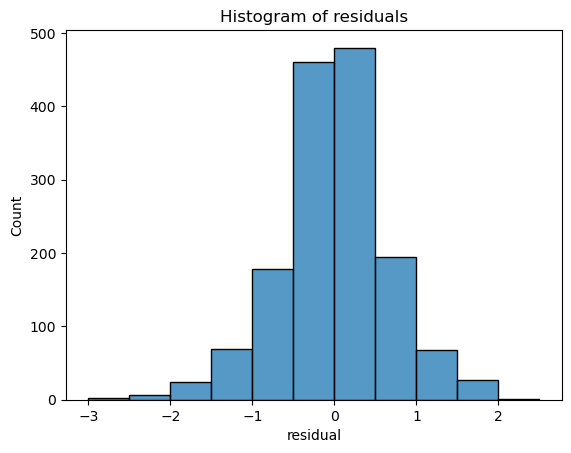

In [51]:
# Visualize the distribution of the `residuals`
sns.histplot(results['residual'], bins=np.arange(-3,3,0.5))
plt.title('Histogram of residuals')
plt.show()

In [52]:
# Calculate residual mean
results['residual'].mean()

-0.0029143071545884255

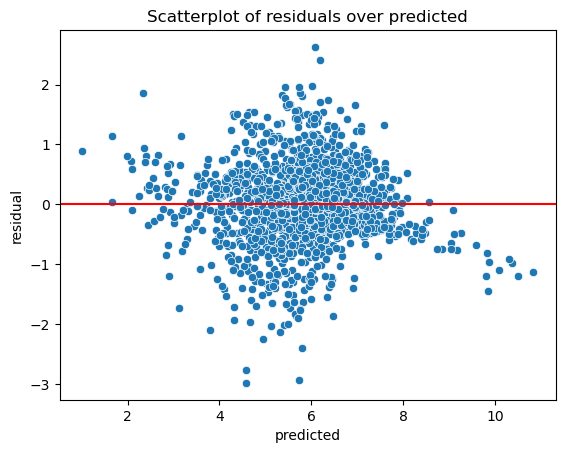

In [53]:
# Create a scatterplot of `residuals` over `predicted`
sns.scatterplot(x=results['predicted'], y=results['residual'])
plt.axhline(0, c='red')
plt.title('Scatterplot of residuals over predicted')
plt.show()

In [54]:
# Output the model's coefficients
coefficients = pd.DataFrame(LR.coef_, index=X.columns).T
coefficients

,Year,Duration,Votes,actor1_encoded,actor2_encoded,actor3_encoded,director_encoded,genre_encoded
0,0.001163,0.003416,0.000005,0.246797,0.271906,0.337149,0.410225,0.136947


In [55]:
LR_cv = LinearRegression()

k = 5 # Number of folds
cv = KFold(n_splits=k, shuffle=True, random_state=42)  

scores = cross_val_score(LR_cv, X, y, cv=cv, scoring='r2')

print("R^2 scores:", scores)
print("Mean R^2:", scores.mean())
print("Standard Deviation of R^2:", scores.std())

R^2 scores: [0.75805291 0.7593615  0.76172776 0.75988008 0.76146141]
Mean R^2: 0.7600967351040423
Standard Deviation of R^2: 0.0013628876140523982


In [56]:
# Create a Ridge regression model
RR = Ridge()
# Define the hyperparameter grid
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
# Create a grid search object
grid_search_RR = GridSearchCV(RR, param_grid, cv=5, scoring='r2')
# Fit the grid search to your data
grid_search_RR.fit(X_train, y_train)

grid_search_RR.best_params_

{'alpha': 10}

In [57]:
y_pred_RR = grid_search_RR.predict(X_test)

print('R^2: ', r2_score(y_test, y_pred_RR))
print('MAE: ',mean_absolute_error(y_test, y_pred_RR))
print('MSE: ', mean_squared_error(y_test, y_pred_RR))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_RR)))

R^2:  0.7580764292819027
MAE:  0.4983562852139371
MSE:  0.4482450371240177
RMSE:  0.6695110433174479


In [58]:
# Create a Decision tree regression model
tree = DecisionTreeRegressor(random_state=0)
# Define the hyperparameter grid
param_grid = {'max_depth': [None, 10, 20, 30]}
# Create a grid search object
grid_search_tree = GridSearchCV(tree, param_grid, cv=5, scoring='r2')
# Fit the grid search to your data
grid_search_tree.fit(X_train, y_train)

grid_search_tree.best_params_

{'max_depth': 10}

In [59]:
y_pred_tree = grid_search_tree.predict(X_test)

print('R^2: ', r2_score(y_test, y_pred_tree))
print('MAE: ',mean_absolute_error(y_test, y_pred_tree))
print('MSE: ', mean_squared_error(y_test, y_pred_tree))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_tree)))

R^2:  0.707626058940163
MAE:  0.5106472740736313
MSE:  0.5417213695856643
RMSE:  0.7360172345710828


In [60]:
# Create a Random Forest Regressor model
RF = RandomForestRegressor(random_state=0)
param_grid = {'min_samples_leaf': [1, 3, 5]}
grid_search_RF = GridSearchCV(RF, param_grid, cv=5, scoring='r2')
# Fit the grid search to the data
grid_search_RF.fit(X_train, y_train)

grid_search_RF.best_params_

{'min_samples_leaf': 3}

In [61]:
y_pred_RF = grid_search_RF.predict(X_test)

print('R^2: ', r2_score(y_test, y_pred_RF))
print('MAE: ',mean_absolute_error(y_test, y_pred_RF))
print('MSE: ', mean_squared_error(y_test, y_pred_RF))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_RF)))

R^2:  0.7968416509125918
MAE:  0.4269651381450664
MSE:  0.37641938509105854
RMSE:  0.6135302642014153
